Epoch 1/2 - Train Loss: 0.5901 - Val Acc: 0.3000
Epoch 2/2 - Train Loss: 0.2883 - Val Acc: 0.6333


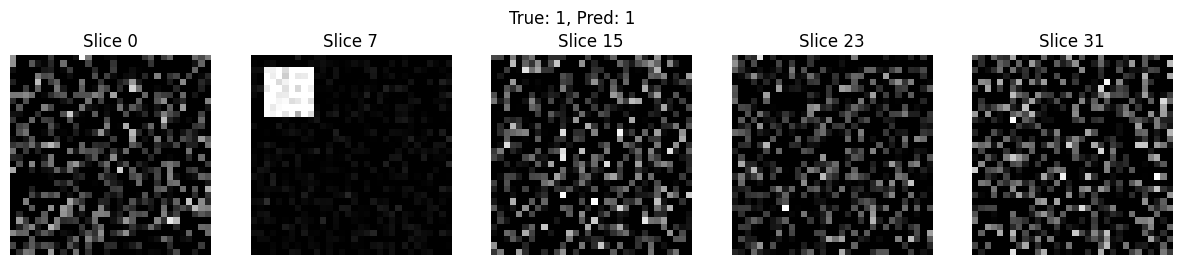

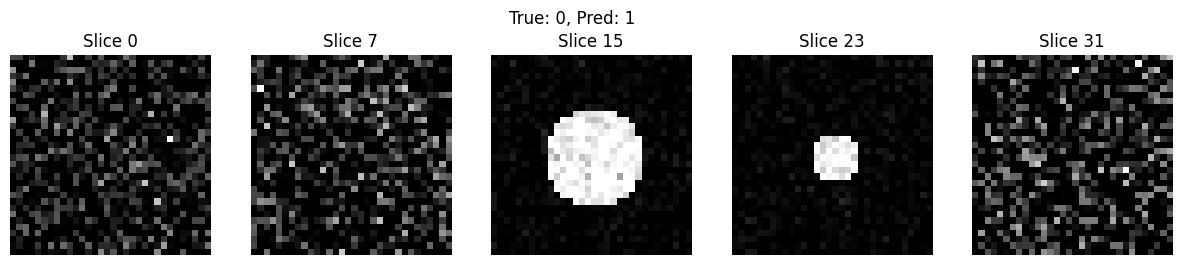

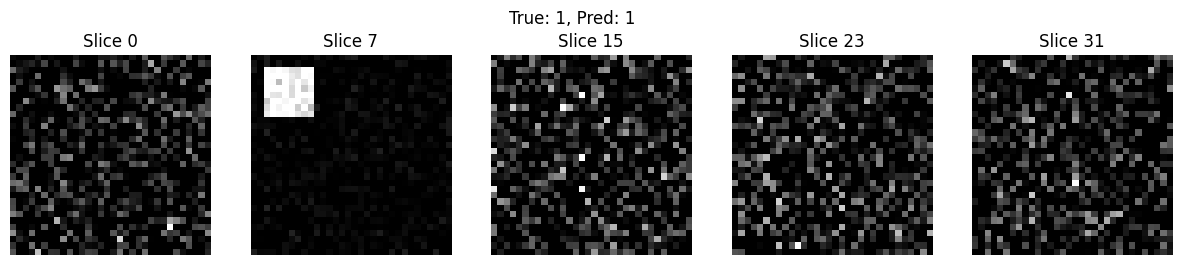

Epoch 1/15 - Train Loss: 0.5465 - Val Acc: 0.3167
Epoch 2/15 - Train Loss: 0.2473 - Val Acc: 0.6667
Epoch 3/15 - Train Loss: 0.1294 - Val Acc: 0.6667
Epoch 4/15 - Train Loss: 0.0884 - Val Acc: 1.0000
Epoch 5/15 - Train Loss: 0.0565 - Val Acc: 1.0000
Epoch 6/15 - Train Loss: 0.0377 - Val Acc: 1.0000
Epoch 7/15 - Train Loss: 0.0286 - Val Acc: 1.0000
Epoch 8/15 - Train Loss: 0.0232 - Val Acc: 1.0000
Epoch 9/15 - Train Loss: 0.0288 - Val Acc: 1.0000
Epoch 10/15 - Train Loss: 0.0288 - Val Acc: 1.0000
Epoch 11/15 - Train Loss: 0.0203 - Val Acc: 1.0000
Epoch 12/15 - Train Loss: 0.0130 - Val Acc: 1.0000
Epoch 13/15 - Train Loss: 0.0107 - Val Acc: 1.0000
Epoch 14/15 - Train Loss: 0.0108 - Val Acc: 1.0000
Epoch 15/15 - Train Loss: 0.0169 - Val Acc: 1.0000


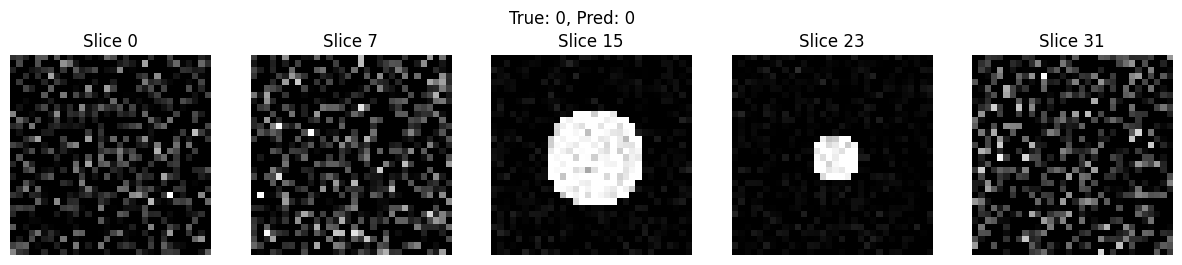

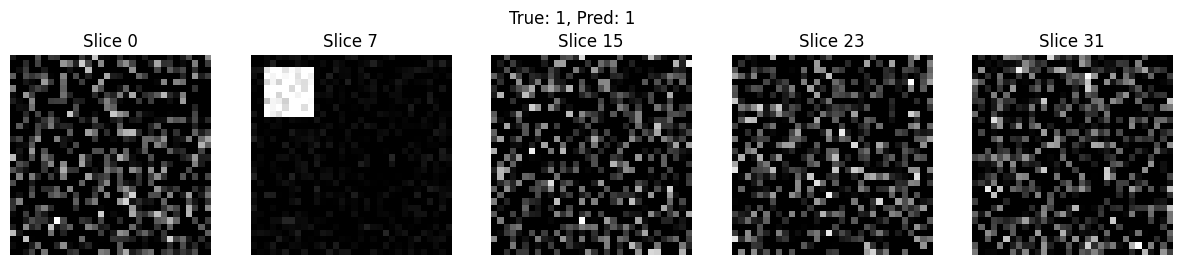

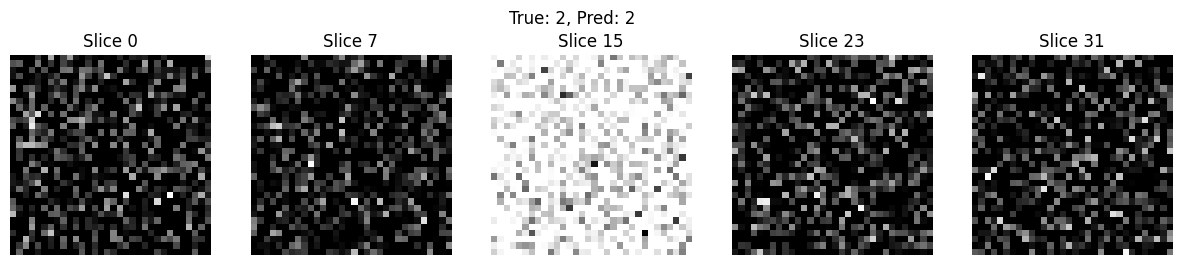

Epoch 1/2 - Train Loss: 0.5208 - Val Acc: 0.5667
Epoch 2/2 - Train Loss: 0.2352 - Val Acc: 0.5667


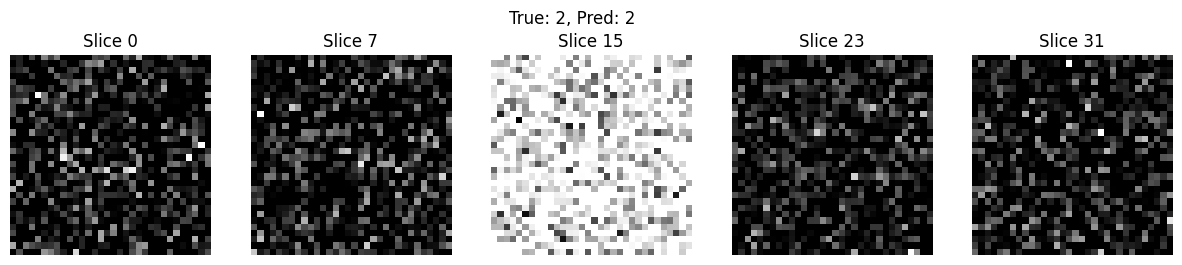

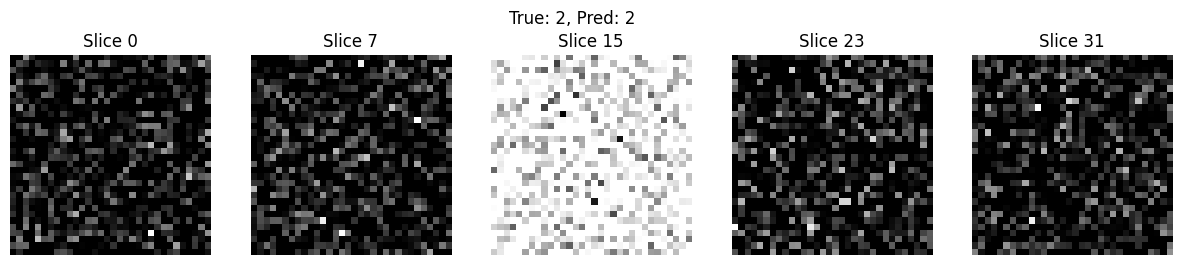

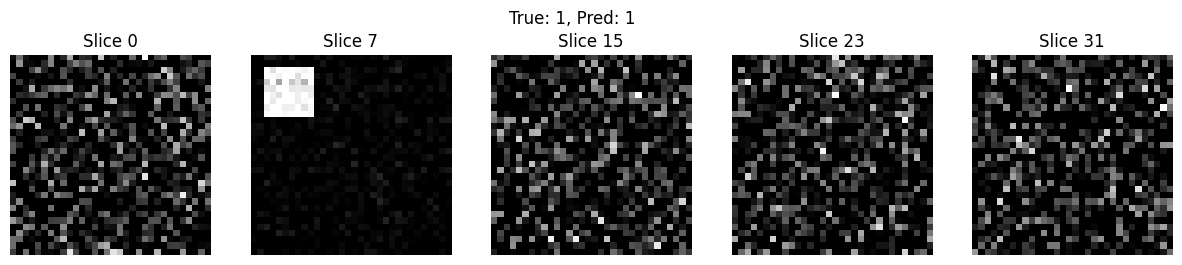

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- Создание синтетического 3D датасета ---
class Synthetic3DDataset(Dataset):
    def __init__(self, num_samples=300, volume_size=(32, 32, 32), num_classes=3):
        self.num_samples = num_samples
        self.volume_size = volume_size
        self.num_classes = num_classes

        self.data = []
        self.labels = []

        for _ in range(num_samples):
            label = np.random.randint(0, num_classes)
            volume = self.generate_volume(label)
            self.data.append(volume)
            self.labels.append(label)

        self.data = np.array(self.data, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)

    def generate_volume(self, label):
        # Генерируем объём с разными "паттернами" для разных классов
        vol = np.zeros(self.volume_size, dtype=np.float32)
        D, H, W = self.volume_size

        if label == 0:
            # Класс 0: сфера посередине
            center = np.array([D//2, H//2, W//2])
            radius = min(D,H,W)//4
            for z in range(D):
                for y in range(H):
                    for x in range(W):
                        if np.linalg.norm(np.array([z,y,x]) - center) < radius:
                            vol[z,y,x] = 1.0 + 0.1*np.random.randn()
        elif label == 1:
            # Класс 1: куб в углу
            vol[2:10, 2:10, 2:10] = 1.0 + 0.1*np.random.randn(8,8,8)
        else:
            # Класс 2: плоскость по середине
            vol[D//2-2:D//2+2,:,:] = 1.0 + 0.1*np.random.randn(4,H,W)

        # Добавим шум
        vol += 0.05 * np.random.randn(*self.volume_size)
        vol = np.clip(vol, 0, 1)
        return vol

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Возвращаем тензор с каналом (1,D,H,W) и метку
        x = torch.tensor(self.data[idx]).unsqueeze(0)
        y = torch.tensor(self.labels[idx])
        return x, y

# --- Модель 3D CNN ---
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1),  # выходной размер (64,1,1,1)

            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# --- Визуализация срезов 3D объёма ---
def visualize_volume_slices(volume_tensor, title="Volume slices"):
    # volume_tensor shape: (1,D,H,W)
    volume = volume_tensor.squeeze(0).cpu().numpy()
    D = volume.shape[0]

    fig, axes = plt.subplots(1,5, figsize=(15,3))
    indices = np.linspace(0, D-1, 5).astype(int)
    for i, idx in enumerate(indices):
        axes[i].imshow(volume[idx], cmap='gray')
        axes[i].set_title(f"Slice {idx}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# --- Основной цикл обучения ---
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = Synthetic3DDataset(num_samples=300)
    train_len = int(len(dataset)*0.8)
    val_len = len(dataset) - train_len

    train_ds, val_ds = random_split(dataset, [train_len,val_len])

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = Simple3DCNN(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    epochs = 2
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch,y_batch in train_loader:
            x_batch,y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            out = model(x_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for x_batch,y_batch in val_loader:
                x_batch,y_batch = x_batch.to(device), y_batch.to(device)
                out = model(x_batch)
                preds = out.argmax(dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(y_batch.cpu().numpy())

        train_loss_avg = np.mean(train_losses)
        val_acc = accuracy_score(val_labels,val_preds)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_avg:.4f} - Val Acc: {val_acc:.4f}")

    # Визуализируем пару примеров из валидации с предсказаниями
    model.eval()
    x_sample,y_sample = next(iter(val_loader))
    x_sample,y_sample = x_sample.to(device), y_sample.to(device)
    out_sample = model(x_sample)
    preds_sample = out_sample.argmax(dim=1).cpu().numpy()

    for i in range(min(3,len(x_sample))):
        visualize_volume_slices(x_sample[i].cpu(), title=f"True: {y_sample[i].item()}, Pred: {preds_sample[i]}")

if __name__ == "__main__":
    train()
    # Визуализируем пару примеров из валидации с предсказаниями
    model.eval()
    x_sample,y_sample = next(iter(val_loader))
    x_sample,y_sample = x_sample.to(device), y_sample.to(device)
    out_sample = model(x_sample)
    preds_sample = out_sample.argmax(dim=1).cpu().numpy()

    for i in range(min(3,len(x_sample))):
        visualize_volume_slices(x_sample[i].cpu(), title=f"True: {y_sample[i].item()}, Pred: {preds_sample[i]}")
